Импорт и загрузка данных

In [ ]:
import zipfile
import os
from google.colab import drive
from tqdm import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from torchsummary import summary
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from torchvision import transforms
drive.mount('/content/drive')
import matplotlib.pyplot as plt
zip_file = '/content/drive/MyDrive/data.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall(path='/content/Data/')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import f1_score
from itertools import chain

Датасет

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "/content/Data/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append([img_path, class_name])
        self.class_map = {"True" : 1, "False": 0}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize([0, 0, 0], [1, 1, 1])
        ])
        
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        img_tensor.float(), class_id
        return transform(img), class_id

In [ ]:
data = CustomDataset()

In [ ]:
train_perc = 0.8

In [ ]:
train_size = int(train_perc * len(data))
test_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, test_size])

Определение модели

In [ ]:
class Vers_min_2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 
            
            # convolutional layer 2
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 
            
            # convolutional layer 3
            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 

            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) 
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=4* 5* 5, out_features=10),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=10, out_features=2)
        )
    
    def forward(self, x):
        out = self.cnn_layers(x)
        #print(out.shape)
        out = out.view(-1, 4* 5* 5) # flatten the values
        out = self.linear_layers(out)
        return out

In [ ]:
class Vers_min_3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # convolutional layer 2
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 
            
            # convolutional layer 3
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) 
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=8* 5* 5, out_features=10),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=10, out_features=2)
        )
    
    def forward(self, x):
        out = self.cnn_layers(x)
        #print(out.shape)
        out = out.view(-1, 8* 5* 5) # flatten the values
        out = self.linear_layers(out)
        return out

In [ ]:
model = Vers_min_3()
if torch.cuda.is_available():
    model.cuda()
summary(model, (3, 116, 116))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 114, 114]             112
       BatchNorm2d-2          [-1, 4, 114, 114]               8
              ReLU-3          [-1, 4, 114, 114]               0
         MaxPool2d-4            [-1, 4, 57, 57]               0
            Conv2d-5            [-1, 8, 55, 55]             296
       BatchNorm2d-6            [-1, 8, 55, 55]              16
              ReLU-7            [-1, 8, 55, 55]               0
         MaxPool2d-8            [-1, 8, 27, 27]               0
            Conv2d-9            [-1, 8, 25, 25]             584
      BatchNorm2d-10            [-1, 8, 25, 25]              16
             ReLU-11            [-1, 8, 25, 25]               0
        MaxPool2d-12            [-1, 8, 12, 12]               0
           Conv2d-13            [-1, 8, 10, 10]             584
      BatchNorm2d-14            [-1, 8,

In [ ]:
model = Vers_min_2()
if torch.cuda.is_available():
    model.cuda()
summary(model, (3, 116, 116))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 114, 114]             112
       BatchNorm2d-2          [-1, 4, 114, 114]               8
              ReLU-3          [-1, 4, 114, 114]               0
         MaxPool2d-4            [-1, 4, 57, 57]               0
            Conv2d-5            [-1, 8, 55, 55]             296
       BatchNorm2d-6            [-1, 8, 55, 55]              16
              ReLU-7            [-1, 8, 55, 55]               0
         MaxPool2d-8            [-1, 8, 27, 27]               0
            Conv2d-9            [-1, 4, 25, 25]             292
      BatchNorm2d-10            [-1, 4, 25, 25]               8
             ReLU-11            [-1, 4, 25, 25]               0
        MaxPool2d-12            [-1, 4, 12, 12]               0
           Conv2d-13            [-1, 4, 10, 10]             148
      BatchNorm2d-14            [-1, 4,

In [ ]:
DEVICE = torch.device("cuda")

Функции для обучения

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    labels_true = []
    labels_pred = []
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE).float()
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            
        running_loss += loss.item() * inputs.size(0)
        labels_true = np.concatenate((labels_true, labels.data.cpu().numpy()))
        labels_pred = np.concatenate((labels_pred, preds.cpu().numpy()))
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    return val_loss, f1_score(labels_true.astype(int),labels_pred.astype(int))

    

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer): ###обучение
    running_loss = 0.0
    labels_true = []
    labels_pred = []
    processed_size = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE).float()
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
        labels_true = np.concatenate((labels_true, labels.data.cpu().numpy()))
        labels_pred = np.concatenate((labels_pred, preds.cpu().numpy()))

    train_loss = running_loss / processed_size
    
    return train_loss, f1_score(labels_true.astype(int),labels_pred.astype(int))

In [ ]:
def train(train_dataset, val_dataset, model, opt, epochs, batch_size):#функция обучения
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:

optimizer  = torch.optim.AdamW(chain(model.parameters()), lr=1e-4/2)

In [ ]:
history = train(train_dataset, val_dataset, model,optimizer, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.2814488226687724


epoch:   5%|▌         | 1/20 [00:43<13:54, 43.90s/it]


Epoch 001 train_loss: 0.2814     val_loss 0.1095 train_acc 0.7751 val_acc 0.9486
loss 0.055618459176229394


epoch:  10%|█         | 2/20 [01:29<13:23, 44.67s/it]


Epoch 002 train_loss: 0.0556     val_loss 0.0338 train_acc 0.9567 val_acc 0.9664
loss 0.02670452155230658


epoch:  15%|█▌        | 3/20 [02:11<12:21, 43.62s/it]


Epoch 003 train_loss: 0.0267     val_loss 0.0168 train_acc 0.9796 val_acc 0.9903
loss 0.015924755639539274


epoch:  20%|██        | 4/20 [02:51<11:16, 42.27s/it]


Epoch 004 train_loss: 0.0159     val_loss 0.0111 train_acc 0.9897 val_acc 0.9932
loss 0.011739022717441523


epoch:  25%|██▌       | 5/20 [03:32<10:25, 41.67s/it]


Epoch 005 train_loss: 0.0117     val_loss 0.0089 train_acc 0.9917 val_acc 0.9953
loss 0.009625052951333394


epoch:  30%|███       | 6/20 [04:13<09:40, 41.43s/it]


Epoch 006 train_loss: 0.0096     val_loss 0.0073 train_acc 0.9932 val_acc 0.9956
loss 0.00824515298108242


epoch:  35%|███▌      | 7/20 [04:53<08:52, 40.98s/it]


Epoch 007 train_loss: 0.0082     val_loss 0.0059 train_acc 0.9952 val_acc 0.9973
loss 0.006988860122510425


epoch:  40%|████      | 8/20 [05:35<08:17, 41.47s/it]


Epoch 008 train_loss: 0.0070     val_loss 0.0045 train_acc 0.9955 val_acc 0.9976
loss 0.006167878320057233


epoch:  45%|████▌     | 9/20 [06:16<07:32, 41.17s/it]


Epoch 009 train_loss: 0.0062     val_loss 0.0040 train_acc 0.9961 val_acc 0.9985
loss 0.005432458984011429


epoch:  50%|█████     | 10/20 [06:56<06:49, 40.91s/it]


Epoch 010 train_loss: 0.0054     val_loss 0.0038 train_acc 0.9963 val_acc 0.9985
loss 0.004905768461708114


epoch:  55%|█████▌    | 11/20 [07:37<06:06, 40.75s/it]


Epoch 011 train_loss: 0.0049     val_loss 0.0032 train_acc 0.9971 val_acc 0.9985
loss 0.004644029059106478


epoch:  60%|██████    | 12/20 [08:20<05:31, 41.45s/it]


Epoch 012 train_loss: 0.0046     val_loss 0.0030 train_acc 0.9968 val_acc 0.9988
loss 0.004092483998128947


epoch:  65%|██████▌   | 13/20 [09:01<04:50, 41.55s/it]


Epoch 013 train_loss: 0.0041     val_loss 0.0036 train_acc 0.9975 val_acc 0.9976
loss 0.003741360308488798


epoch:  70%|███████   | 14/20 [09:42<04:07, 41.32s/it]


Epoch 014 train_loss: 0.0037     val_loss 0.0028 train_acc 0.9977 val_acc 0.9988
loss 0.0034690167349909788


epoch:  75%|███████▌  | 15/20 [10:25<03:29, 41.83s/it]


Epoch 015 train_loss: 0.0035     val_loss 0.0024 train_acc 0.9982 val_acc 0.9991
loss 0.002984605738404311


epoch:  80%|████████  | 16/20 [11:06<02:45, 41.50s/it]


Epoch 016 train_loss: 0.0030     val_loss 0.0026 train_acc 0.9982 val_acc 0.9985
loss 0.002927066044322838


epoch:  85%|████████▌ | 17/20 [11:49<02:05, 41.84s/it]


Epoch 017 train_loss: 0.0029     val_loss 0.0020 train_acc 0.9980 val_acc 0.9988
loss 0.0026498009540364595


epoch:  90%|█████████ | 18/20 [12:35<01:26, 43.27s/it]


Epoch 018 train_loss: 0.0026     val_loss 0.0019 train_acc 0.9985 val_acc 0.9988
loss 0.0023332508829352967


epoch:  95%|█████████▌| 19/20 [13:17<00:42, 42.83s/it]


Epoch 019 train_loss: 0.0023     val_loss 0.0019 train_acc 0.9985 val_acc 0.9991
loss 0.002177075380671745


epoch: 100%|██████████| 20/20 [13:58<00:00, 41.91s/it]


Epoch 020 train_loss: 0.0022     val_loss 0.0017 train_acc 0.9985 val_acc 0.9988


In [ ]:
min_m_3 = history.copy()

In [ ]:
min_m_2_t = []
min_m_2_v = []
for i in min_m_2:
  min_m_2_t.append(i[1])
  min_m_2_v.append(i[3])

In [ ]:
min_m_3_t = []
min_m_3_v = []
for i in min_m_3:
  min_m_3_t.append(i[1])
  min_m_3_v.append(i[3])

In [ ]:
ind = slice(5, 20)

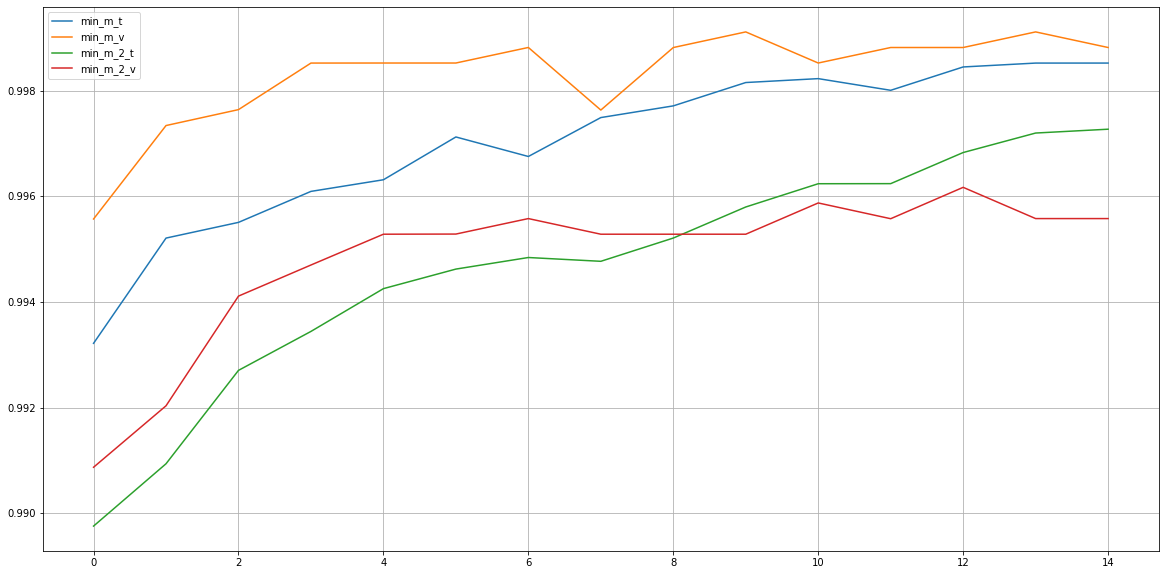

In [ ]:
plt.figure(figsize=(20,10)) 
plt.grid()
plt.plot(min_m_3_t[ind])
plt.plot(min_m_3_v[ind])
plt.plot(min_m_2_t[ind])
plt.plot(min_m_2_v[ind])
plt.legend(['min_m_3_t','min_m_3_v','min_m_2_t','min_m_2_v'])

Как видно, модели обучаются стабильно до 7-ой эпохи

In [ ]:
model_1 = Vers_min_3()
if torch.cuda.is_available():
    model_1.cuda()
summary(model_1, (3, 116, 116))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 114, 114]             112
       BatchNorm2d-2          [-1, 4, 114, 114]               8
              ReLU-3          [-1, 4, 114, 114]               0
         MaxPool2d-4            [-1, 4, 57, 57]               0
            Conv2d-5            [-1, 8, 55, 55]             296
       BatchNorm2d-6            [-1, 8, 55, 55]              16
              ReLU-7            [-1, 8, 55, 55]               0
         MaxPool2d-8            [-1, 8, 27, 27]               0
            Conv2d-9            [-1, 8, 25, 25]             584
      BatchNorm2d-10            [-1, 8, 25, 25]              16
             ReLU-11            [-1, 8, 25, 25]               0
        MaxPool2d-12            [-1, 8, 12, 12]               0
           Conv2d-13            [-1, 8, 10, 10]             584
      BatchNorm2d-14            [-1, 8,

In [ ]:
model_2 = Vers_min_2()
if torch.cuda.is_available():
    model_2.cuda()
summary(model_2, (3, 116, 116))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 114, 114]             112
       BatchNorm2d-2          [-1, 4, 114, 114]               8
              ReLU-3          [-1, 4, 114, 114]               0
         MaxPool2d-4            [-1, 4, 57, 57]               0
            Conv2d-5            [-1, 8, 55, 55]             296
       BatchNorm2d-6            [-1, 8, 55, 55]              16
              ReLU-7            [-1, 8, 55, 55]               0
         MaxPool2d-8            [-1, 8, 27, 27]               0
            Conv2d-9            [-1, 4, 25, 25]             292
      BatchNorm2d-10            [-1, 4, 25, 25]               8
             ReLU-11            [-1, 4, 25, 25]               0
        MaxPool2d-12            [-1, 4, 12, 12]               0
           Conv2d-13            [-1, 4, 10, 10]             148
      BatchNorm2d-14            [-1, 4,

In [ ]:
optimizer_1  = torch.optim.AdamW(chain(model_1.parameters()), lr=1e-4/2)
optimizer_2  = torch.optim.AdamW(chain(model_2.parameters()), lr=1e-4/2)

In [ ]:
history_1 = train(train_dataset, val_dataset, model_1,optimizer_1, epochs=7, batch_size=64)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.2887941328500346


epoch:  14%|█▍        | 1/7 [00:43<04:19, 43.20s/it]


Epoch 001 train_loss: 0.2888     val_loss 0.1051 train_acc 0.7275 val_acc 0.9577
loss 0.04848788287200823


epoch:  29%|██▊       | 2/7 [01:23<03:27, 41.57s/it]


Epoch 002 train_loss: 0.0485     val_loss 0.0305 train_acc 0.9649 val_acc 0.9682
loss 0.021783326685629798


epoch:  43%|████▎     | 3/7 [02:04<02:44, 41.10s/it]


Epoch 003 train_loss: 0.0218     val_loss 0.0163 train_acc 0.9843 val_acc 0.9895
loss 0.013718712891680227


epoch:  57%|█████▋    | 4/7 [02:44<02:02, 40.87s/it]


Epoch 004 train_loss: 0.0137     val_loss 0.0113 train_acc 0.9930 val_acc 0.9944
loss 0.010396282808148914


epoch:  71%|███████▏  | 5/7 [03:25<01:21, 40.78s/it]


Epoch 005 train_loss: 0.0104     val_loss 0.0093 train_acc 0.9953 val_acc 0.9944
loss 0.008458359821139209


epoch:  86%|████████▌ | 6/7 [04:06<00:40, 40.83s/it]


Epoch 006 train_loss: 0.0085     val_loss 0.0075 train_acc 0.9958 val_acc 0.9953
loss 0.007230711433426006


epoch: 100%|██████████| 7/7 [04:47<00:00, 41.04s/it]


Epoch 007 train_loss: 0.0072     val_loss 0.0072 train_acc 0.9961 val_acc 0.9956


In [ ]:
torch.save(model_1, './model_1')

In [ ]:
history = train(train_dataset, val_dataset, model_2,optimizer_2, epochs=7, batch_size=64)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.4470221997335517


epoch:  14%|█▍        | 1/7 [00:41<04:09, 41.57s/it]


Epoch 001 train_loss: 0.4470     val_loss 0.2662 train_acc 0.4945 val_acc 0.8362
loss 0.11081663560683776


epoch:  29%|██▊       | 2/7 [01:22<03:26, 41.31s/it]


Epoch 002 train_loss: 0.1108     val_loss 0.0554 train_acc 0.9277 val_acc 0.9529
loss 0.04197686899878156


epoch:  43%|████▎     | 3/7 [02:03<02:44, 41.17s/it]


Epoch 003 train_loss: 0.0420     val_loss 0.0333 train_acc 0.9680 val_acc 0.9747
loss 0.02622800146410838


epoch:  57%|█████▋    | 4/7 [02:44<02:02, 41.00s/it]


Epoch 004 train_loss: 0.0262     val_loss 0.0222 train_acc 0.9810 val_acc 0.9894
loss 0.01844881013365794


epoch:  71%|███████▏  | 5/7 [03:24<01:21, 40.82s/it]


Epoch 005 train_loss: 0.0184     val_loss 0.0176 train_acc 0.9900 val_acc 0.9906
loss 0.014645173248519827


epoch:  86%|████████▌ | 6/7 [04:05<00:40, 40.72s/it]


Epoch 006 train_loss: 0.0146     val_loss 0.0143 train_acc 0.9921 val_acc 0.9935
loss 0.012552347172805229


epoch: 100%|██████████| 7/7 [04:46<00:00, 40.88s/it]


Epoch 007 train_loss: 0.0126     val_loss 0.0132 train_acc 0.9934 val_acc 0.9938


In [ ]:
torch.save(model_2, './model_2')